# Sparse Subspace Clustering
#### Due March 24, 2023, 11:59PM

The general idea is that there are $∞$ many ways to define points in terms of other points. Another way to say this: there are infinitely many ways to linearly depending points.

This paper introduces Sparse Subspace Clustering (SSC), an algorithm that solves a sparse optimazation using spectral clustering. Beacuse sparse optimization is NP-Hard, the paper asserts a convex relaxation. 

#### Algorithm
1. Input a set of points lying need a union of n-linear subspaces 
2. Solve the sparse optimazation program in Eq. 5
3. Normalize the columns, $C$
4. Form a similarity graph with N nodes representing the data points with the edge weights being $\mathbf{W} = |C|+|C|$.
5. Apply spectral clustering [26] to similarity graph. 
6. Output results from Step 5. 


### mySpectralClustering Function

In [7]:
import numpy as np
import scipy as sp
import math
from numpy import linalg as lin
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist
from scipy.optimize import linear_sum_assignment

def mySpectralClustering(W, K, normalized):
    r"""
    Customized version of Spectral Clustering

    Inputs:
    -------
        W: weighted adjacency matrix of size N x N
        K: number of output clusters
        normalized: 1 for normalized Laplacian, 0 for unnormalized
    
    Outputs:
    -------
        estLabels: estimated cluster labels
        Y: transformed data matrix of size K x N
    """

    degMat = np.diag(np.sum(W, axis=0))
    L = degMat - W
    n_init = 10
    max_iter = 300

    if normalized == 0:
        D, V = lin.eig(L)
        V_real = V.real
        inds = np.argsort(D)
        Y = V_real[:, inds[0:K]].T
        
        k_means = KMeans(n_clusters=K, n_init=n_init, max_iter=max_iter).fit(Y.T)
        estLabels = k_means.labels_
    else:
        # Invert degree matrix
        degInv = np.diag(1.0 / np.diag(degMat))
        Ln = degInv @ L

        # Eigen decomposition
        D, V = lin.eig(Ln)
        V_real = V.real
        inds = np.argsort(D)
        Y = V_real[:, inds[0:K]].T

        k_means = KMeans(n_clusters=K, n_init=n_init, max_iter=max_iter).fit(Y.T)
        estLabels = k_means.labels_
    
    return estLabels, Y

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def SparseSubspaceClustering(Xtrain, K, lam=1e-4, P=15, normalize=0):
    r"""
    Sparse Subspace Clutering with P Coefficients

    Inputs:
    -------
        Xtrain: (D x N) Data matrix where the columns are samples of D-dimensional data
        K: number of output clusters for spectral clustering
        lam: weight of regularization term
        P: number of coefficients used to reconstruct a data point 
        normalized: 1 for normalized Laplacian for spectral clustering, 0 for unnormalized 
    Outputs:
    -------
        estLabels: estimated cluster labels
        Y: transformed data matrix of size K x N
    """

    N, D = Xtrain.shape
    C = np.zeros((D, D))
    for ii, y in enumerate(Xtrain.T):
        ### Documentation here: https://www.cvxpy.org/
        Xtrain_no_y = np.delete(Xtrain, ii, axis=1) 
        c = cp.Variable(D-1)
        prob = cp.Problem(cp.Minimize(cp.norm(c) + lam*cp.norm(y - Xtrain_no_y @ c)), [cp.sum(c) == 1])
        result = prob.solve()
        c_values = np.insert(c.value, ii, 0)
        ## Sparsify manually. Really a sad state of affairs. 
        idx = np.argpartition(c_values, -P)[-P:]
        new_c = np.zeros(D)
        new_c[idx] = c_values[idx]

        C[ii,:] = new_c
        C[:,ii] = new_c

    C = np.nan_to_num(C)
    for ii in range(D):
        C[:,ii] = C[:,ii] / np.linalg.norm(C[:,ii], ord=np.inf)

    W = abs(C) + abs(C.T)
    W = np.nan_to_num(W)

    estLabels, Y = mySpectralClustering(W, K, normalize)
    return estLabels, Y

### Synthetic Experiment

Generate synthetic data from two orthogonal bases [1,1,0] and [1,0,1].

In [66]:
import numpy as np

N = 50
D = 3
half = int(N/2)
x_train = np.zeros((D, N))
y_train = np.zeros(N)
y_train[half:] = 1

for ii in range(N):
    if ii < int(N/2):
        x_train[:,ii] = np.array([2*np.random.randint(0, 10), 2*np.random.randint(0, 10), 0])
    else:
        x_train[:,ii] = np.array([2*np.random.randint(0, 10), 0, 2*np.random.randint(0, 10)])
        
## Comment out when running tests. Helps makes things run faster when demonstrating. 
x_train[:,0] = [1,1,0]
x_train[:,-1] = [1,0,1]

Total Accuracy: 0.92


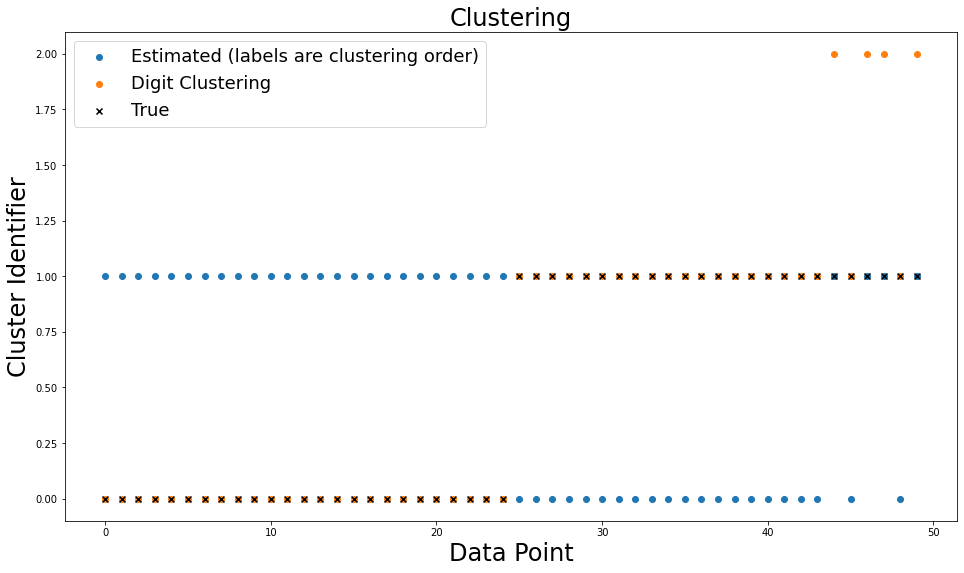

In [92]:
K = 2
P = 50
lam = 1e-2

estLabels, Y = SparseSubspaceClustering(x_train, K, lam, P, normalize=0)

## This adjusts so the clusters are assigned to the digits. The cluster numbers are assigned based off of which clustered first. 
counts = np.bincount(estLabels[:half])
clust0 = np.argmax(counts)

counts = np.bincount(estLabels[half:])
clust1 = np.argmax(counts)

newEstLabels = np.concatenate([(estLabels[:half] - clust0), (estLabels[half:] - clust1 + 1)])

acc0 = sum((estLabels[:half] - clust0) == y_train[:half])
acc1 = sum((estLabels[half:] - clust1 + 1) == y_train[half:])
tot_acc = (acc0 + acc1) / N
print('Total Accuracy:', tot_acc)

plt.figure(figsize=(16, 9))
plt.title("Clustering", fontsize=f)
plt.scatter(np.arange(0, N, 1), estLabels, label='Estimated (labels are clustering order)')
plt.scatter(np.arange(0, N, 1), newEstLabels, label='Digit Clustering')
plt.scatter(np.arange(0, N, 1), y_train, marker='x', c='k', label='True')
plt.xlabel("Data Point", fontsize=f)
plt.ylabel("Cluster Identifier", fontsize=f)
plt.legend(fontsize=18)

### Real World Experiment: MNIST Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import cvxpy as cp
import time

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


The below line of code shows theres 60,000 images with 28x28 dimensions. I am only going to get $N$ samples from the digits 0-3. 

In [ ]:
print(x_train.shape)
print(y_train.shape)

N = 200
idx_0s = np.where(y_train == 0)[0][:N]
idx_1s = np.where(y_train == 1)[0][:N]
idx_2s = np.where(y_train == 2)[0][:N]
idx_3s = np.where(y_train == 3)[0][:N]
idx_5s = np.where(y_train == 5)[0][:N]
subsampled_indices = np.concatenate([idx_0s, idx_1s, idx_2s, idx_3s])

# ## Using only 0s, 1s, and 2s
# It does not like the digit 1. 
subsampled_indices = np.concatenate([idx_0s, idx_2s, idx_5s])
subsampled_indices = np.concatenate([idx_0s, idx_5s])


Xtrain = x_train[subsampled_indices, :, :].reshape(len(subsampled_indices), 28*28).T
Ytrain = y_train[subsampled_indices]

X0 = x_train[idx_0s, :, :].reshape(N, 28*28)
X1 = x_train[idx_1s, :, :].reshape(N, 28*28)
X2 = x_train[idx_2s, :, :].reshape(N, 28*28)
X3 = x_train[idx_3s, :, :].reshape(N, 28*28)

print(Xtrain.shape)
print(Ytrain.shape)

(60000, 28, 28)
(60000,)
(784, 400)
(400,)


Section 7.2 seems to suggest that the "knee" occurs when the singular values start tapering off. It appears to me that the "knee" occurs at 10-15 singular values. Maybe even 20.

The images can be modeled as corrupted data points lying close to a union of 10-20-dimensional subspaces. We will see about that. It might just be like 5 with a bunch of unused subspaces. 

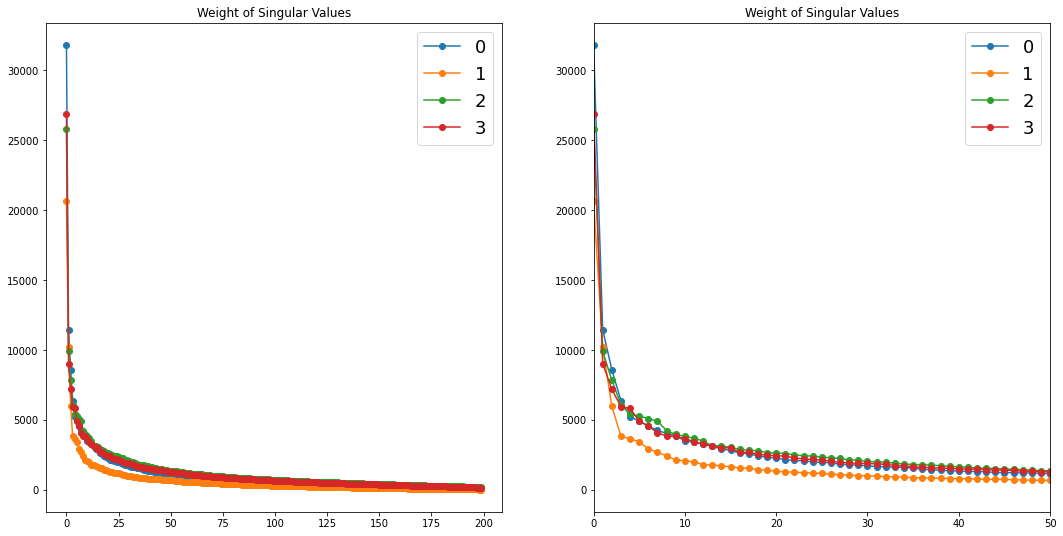

In [ ]:
_, s0, _ = np.linalg.svd(X0)
_, s1, _ = np.linalg.svd(X1)
_, s2, _ = np.linalg.svd(X2)
_, s3, _ = np.linalg.svd(X3)

plt.figure(figsize=(18,9))
plt.subplot(1, 2, 1)
plt.title('Weight of Singular Values')
plt.plot(s0, marker='o', label='0')
plt.plot(s1, marker='o', label='1')
plt.plot(s2, marker='o', label='2')
plt.plot(s3, marker='o', label='3')
plt.legend(fontsize=18)
plt.subplot(1, 2, 2)
plt.title('Weight of Singular Values')
plt.plot(s0, marker='o', label='0')
plt.plot(s1, marker='o', label='1')
plt.plot(s2, marker='o', label='2')
plt.plot(s3, marker='o', label='3')
plt.xlim(0, 50)
plt.legend(fontsize=18)

#### Sparse Subspace Clustering MNIST
Keep about 15 coefficients.

Total Accuracy: 0.9


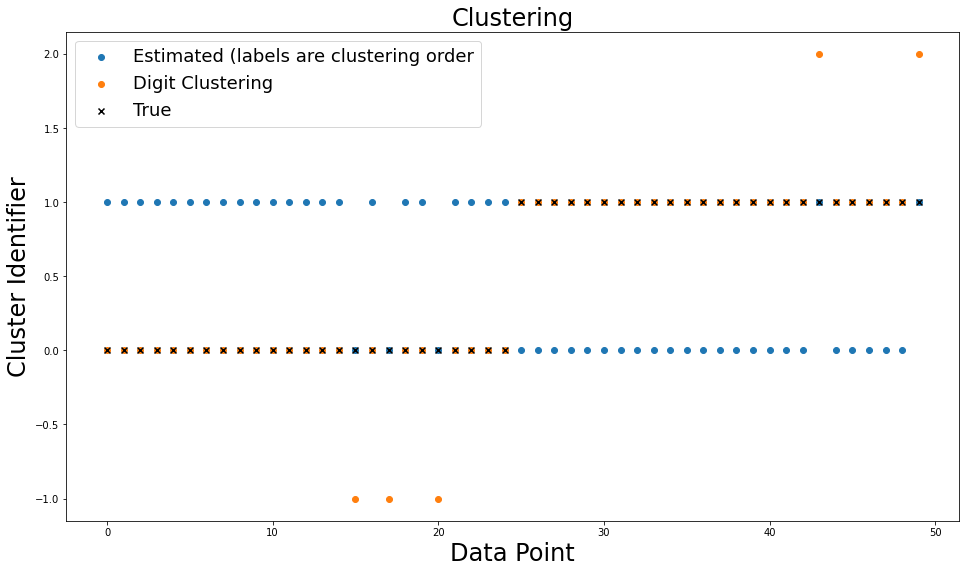

In [91]:
K = 2
P = 15
lam = 1e-6

estLabels, Y = SparseSubspaceClustering(Xtrain, K, lam, P, normalize=0)

## This adjusts so the clusters are assigned to the digits. The cluster numbers are assigned based off of which clustered first. 
counts = np.bincount(estLabels[:half])
clust0 = np.argmax(counts)

counts = np.bincount(estLabels[half:])
clust1 = int(not clust0)

newEstLabels = np.concatenate([(estLabels[:half] - clust0), (estLabels[half:] - clust1 + 1)])

acc0 = sum((estLabels[:half] - clust0) == y_train[:half])
acc1 = sum((estLabels[half:] - clust1 + 1) == y_train[half:])
tot_acc = (acc0 + acc1) / N
print('Total Accuracy:', tot_acc)

plt.figure(figsize=(16, 9))
plt.title("Clustering", fontsize=f)
plt.scatter(np.arange(0, N, 1), estLabels, label='Estimated (labels are clustering order)')
plt.scatter(np.arange(0, N, 1), newEstLabels, label='Digit Clustering')
plt.scatter(np.arange(0, N, 1), y_train, marker='x', c='k', label='True')
plt.xlabel("Data Point", fontsize=f)
plt.ylabel("Cluster Identifier", fontsize=f)
plt.legend(fontsize=18)

### Development Cells. 

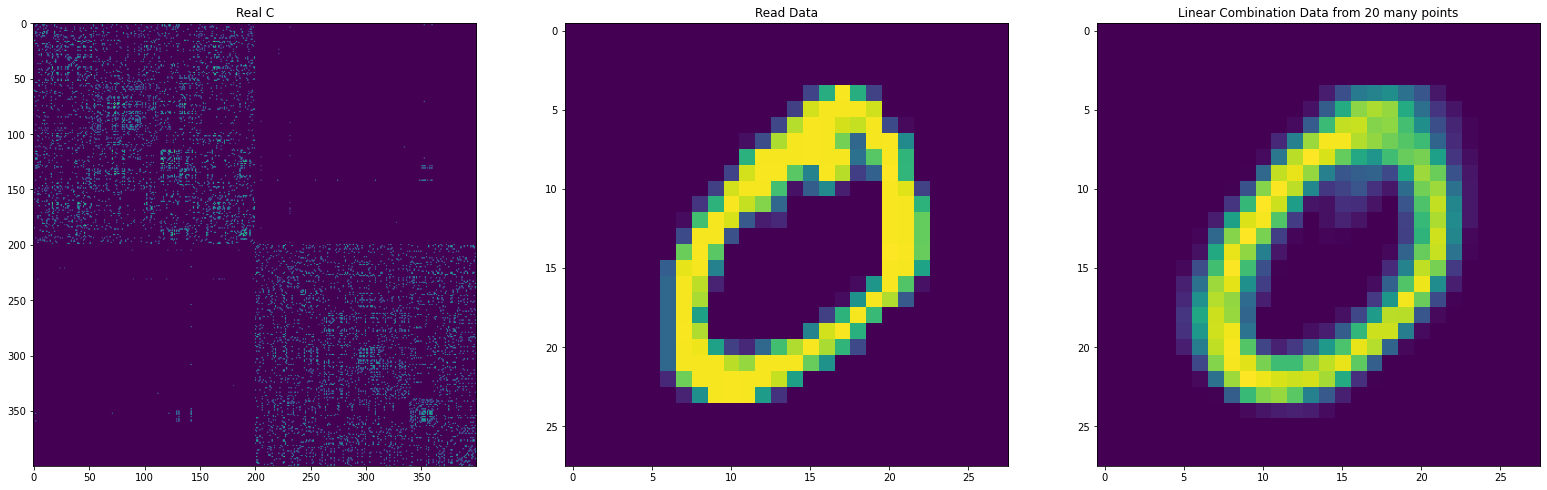

In [ ]:
Xhat = Xtrain @ C
## Visualize for successs
plt.figure(figsize=(27, 9))
plt.subplot(1, 3, 1)
plt.title("Real C")
plt.imshow(C)
plt.subplot(1, 3, 2)
plt.title("Read Data")
plt.imshow(Xtrain[:,0].reshape(28,28))
plt.subplot(1, 3, 3)
plt.title("Linear Combination Data from " + str(P) + ' many points')
plt.imshow(Xhat[:,0].reshape(28,28))

##### Tolerance Sparsifying

In [ ]:
## This is less than ideal. I think the idea is that there's only like X many dimensions worth considering
## The face example says 9 vectors -- which implies only 9 c values are non-zero for each data point? 
## I think we can do the same with the largest X many c values -- kind of like the top X PCA stuff -- which I think is 10-20 from the knee of the spree plot
tol = 1e-3
# idx = np.where(C < tol)[0] ## doesn;t work for 2D matrices
C_tol = C.copy()
C_tol[ C_tol < tol] = 0
Xhat = Xtrain @ C_tol

plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title("Fake C")
plt.imshow(C)
plt.subplot(2, 2, 2)
plt.imshow(Xhat[:,0].reshape(28,28))


plt.subplot(2, 2, 3)
plt.title("Real C")
plt.imshow(C)
plt.subplot(2, 2, 4)
plt.imshow(Xhat[:,0].reshape(28,28))

####Step 2: Do $\frac{c_i}{\| c_i \|_{\infty}} → C$

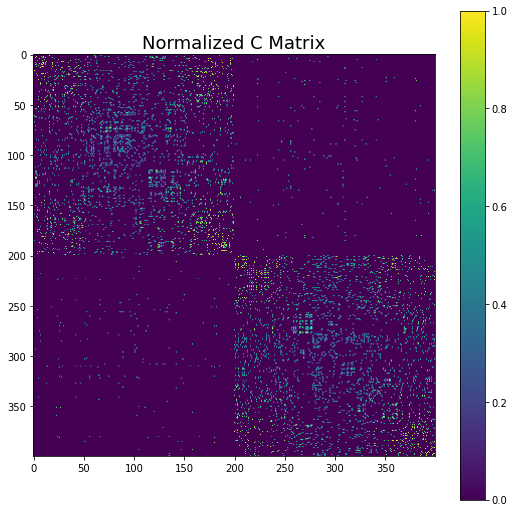

In [ ]:
N, D = C.shape
for ii in range(D):
    C[:,ii] = C[:,ii] / np.linalg.norm(C[:,ii], ord=np.inf)

f= 18
plt.figure(figsize=(9,9))
plt.title("Normalized C Matrix", fontsize=f)
plt.imshow(C)
plt.colorbar()

#### Step 3: Similarity Graph
This is where things might get a little tricky. I do not see the purpose of actually forming a graph. I am going to call back to [Demo 1](http://web.cecs.pdx.edu/~lipor/courses/516/demos/demo-01-description.pdf). We did spectral clustering there. We will do it again here. Instead of an actual graph, we will use the Laplacian.

In [ ]:
W = abs(C) + abs(C.T)
W = np.nan_to_num(W)
# print(np.argwhere(np.isnan(W)))
# np.count_nonzero(~np.isnan(W[:,208]))

#### Step 4: Spectral Cluster
I am going to copy-paste John's Demo Solution code. 

In [ ]:
import numpy as np
import scipy as sp
import math
from numpy import linalg as lin
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist
from scipy.optimize import linear_sum_assignment

def mySpectralClustering(W, K, normalized):
    r"""
    Customized version of Spectral Clustering

    Inputs:
    -------
        W: weighted adjacency matrix of size N x N
        K: number of output clusters
        normalized: 1 for normalized Laplacian, 0 for unnormalized
    
    Outputs:
    -------
        estLabels: estimated cluster labels
        Y: transformed data matrix of size K x N
    """

    degMat = np.diag(np.sum(W, axis=0))
    L = degMat - W
    n_init = 10
    max_iter = 300

    if normalized == 0:
        D, V = lin.eig(L)
        V_real = V.real
        inds = np.argsort(D)
        Y = V_real[:, inds[0:K]].T
        
        k_means = KMeans(n_clusters=K, n_init=n_init, max_iter=max_iter).fit(Y.T)
        estLabels = k_means.labels_
    else:
        # Invert degree matrix
        degInv = np.diag(1.0 / np.diag(degMat))
        Ln = degInv @ L

        # Eigen decomposition
        D, V = lin.eig(Ln)
        V_real = V.real
        inds = np.argsort(D)
        Y = V_real[:, inds[0:K]].T

        k_means = KMeans(n_clusters=K, n_init=n_init, max_iter=max_iter).fit(Y.T)
        estLabels = k_means.labels_
    
    return estLabels, Y

In [ ]:
def train(Xtrain, lam):
    # lam = 1e-4
    P = 15

    N, D = Xtrain.shape
    C = np.zeros((D, D))
    for ii, y in enumerate(Xtrain.T):
        ### Documentation here: https://www.cvxpy.org/
        Xtrain_no_y = np.delete(Xtrain, ii, axis=1) 
        c = cp.Variable(D-1)
        prob = cp.Problem(cp.Minimize(cp.norm(c) + lam*cp.norm(y - Xtrain_no_y @ c)), [cp.sum(c) == 1])
        result = prob.solve()
        c_values = np.insert(c.value, ii, 0)

        ## Sparsify manually. Really a sad state of affairs. 
        idx = np.argpartition(c_values, -P)[-P:]
        new_c = np.zeros(D)
        new_c[idx] = c_values[idx]

        C[ii,:] = new_c
        C[:,ii] = new_c
    N, D = C.shape
    for ii in range(D):
        C[:,ii] = C[:,ii] / np.linalg.norm(C[:,ii], ord=np.inf)
    W = abs(C) + abs(C.T)
    W = np.nan_to_num(W)
    return W

In [ ]:
K = 2

estLabels, Y = mySpectralClustering(W, K, 0)
# print(f"Classification Accuracy (unnormalized): {(sum(estLabels == Ytrain) / len(Ytrain)) * 100}%")

# estLabels, Y = mySpectralClustering(W, K, 1)
# print(f"Classification Error (normalized): {sum(estLabels == Ytrain) / len(Ytrain) * 100}%")

## now pair up the clusters so the error function makes sense


N = 200
predicted_0 = estLabels[:N] 
# predicted_1 = estLabels[N:2*N]
# predicted_2 = estLabels[2*N:3*N]
predicted_5 = estLabels[N+1:]

counts = np.bincount(predicted_0)
clust0 = np.argmax(counts)
accuracy0 = sum((predicted_0 - clust0) == Ytrain[:N])

counts = np.bincount(predicted_5)
clust5 = np.argmax(counts)
accuracy5 = sum((predicted_5 - clust5 + 5) == Ytrain[N+1::])

total_accuracy = (accuracy0 + accuracy5) / (2*N)
print('Accuracy:', total_accuracy)


Classification Accuracy (unnormalized): 0.75%
Classification Error (normalized): 0.25%


In [ ]:
a = 1
print(int(not a))

0


In [ ]:
l_vals = [0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
accuracy = np.zeros(len(l_vals))
for ii, l in enumerate(l_vals):
    W = train(Xtrain, l)
    estLabels, Y = mySpectralClustering(W, K, 0)
    
    N = 200
    predicted_0 = estLabels[:N] 
    predicted_5 = estLabels[N+1:]

    counts = np.bincount(predicted_0)
    clust0 = np.argmax(counts)
    accuracy0 = sum((predicted_0 - clust0) == Ytrain[:N])

    clust5 = int(not clust0)
    accuracy5 = sum((predicted_5 - clust5 + 5) == Ytrain[N+1::])

    total_accuracy = (accuracy0 + accuracy5) / (2*N)
    accuracy[ii] = total_accuracy
    print('Accuracy:', total_accuracy)


Accuracy: 0.4975


<ipython-input-24-712b95ebfabd>:24: RuntimeWarning: invalid value encountered in true_divide
  C[:,ii] = C[:,ii] / np.linalg.norm(C[:,ii], ord=np.inf)


Accuracy: 0.4975


SolverError: ignored

In [ ]:
print(clust0)
print(clust5)
print(estLabels)

0
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


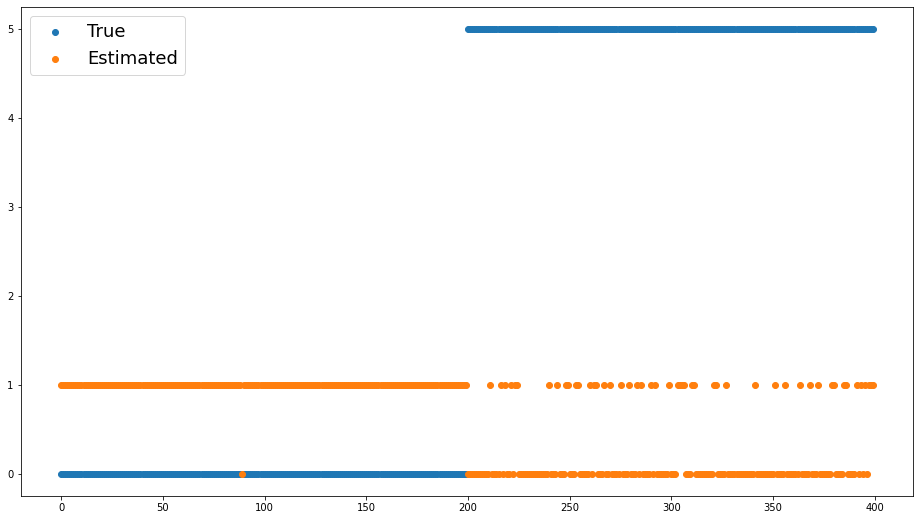

In [ ]:
## Manually Compute Accuracy
t = np.arange(0, len(Ytrain), 1)
plt.figure(figsize=(16, 9))
plt.scatter(t, Ytrain, label='True')
plt.scatter(t, estLabels, label='Estimated')
plt.legend(fontsize=f)

In [ ]:
## now pair up the clusters so the error function makes sense
N = 200
predicted_0 = estLabels[:N] 
# predicted_1 = estLabels[N:2*N]
# predicted_2 = estLabels[2*N:3*N]
predicted_5 = estLabels[N+1:]

counts = np.bincount(predicted_0)
clust0 = np.argmax(counts)
accuracy0 = sum((predicted_0 - clust0) == Ytrain[:N])

counts = np.bincount(predicted_5)
clust5 = np.argmax(counts)
accuracy5 = sum((predicted_5 - clust5 + 5) == Ytrain[N+1::])

total_accuracy = (accuracy0 + accuracy5) / (2*N)
print('Accuracy:', total_accuracy)


Accuracy: 0.8725


In [ ]:
acc = [0.8675, 0.9625,  0.9625,  0.9625,  0.9625,  0.9805, 0.9625,  ]